# US Used Cars (2006 - 2020)

This dataset contains detailed information on approximately 3 million used car listings across the United States from 2005–2020. It is provided as a well-structured CSV (about 9 GB) with dozens of features per car

The dataset provides ~66 features per car, encompassing numeric attributes (mileage, engine size, year, horsepower, etc.) and categorical descriptors (make, model, body type, fuel type, etc.). This richness enables creative feature engineering and the exploration of multiple feature types (numeric, categorical,
ordinal).

## Data Preprocessing

The data is already in a cleaned, structured format (compiled via a web crawler from CarGurus listings). ost fields are well-defined and ready to use. Only a few columns have missing values (e.g. ~9 features with >50% missing can be dropped upfront). And standard techniques like imputation can address any
remaining gaps. No extensive data scraping or text parsing is needed to get started.

### Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
import kagglehub

In [3]:
path = kagglehub.dataset_download("ananaymital/us-used-cars-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\adand\.cache\kagglehub\datasets\ananaymital\us-used-cars-dataset\versions\1


In [4]:
df_path = r"C:\Users\adand\.cache\kagglehub\datasets\ananaymital\us-used-cars-dataset\versions\1\used_cars_data.csv"

In [5]:
data_types = {
    'vin': 'object',
    'back_legroom': 'object',
    'bed': 'object',
    'bed_height': 'object',
    'bed_length': 'object',
    'body_type': 'object',
    'cabin': 'object',
    'city': 'object',
    'city_fuel_economy': 'float32',
    'combine_fuel_economy': 'float32',
    'daysonmarket': 'int64',
    'dealer_zip': 'object',
    'description': 'object',
    'engine_cylinders': 'object',
    'engine_displacement': 'float32',
    'engine_type': 'object',
    'exterior_color': 'object',
    'fleet': 'object',
    'frame_damaged': 'object',
    'franchise_dealer': 'bool',
    'franchise_make': 'object',
    'front_legroom': 'object',
    'fuel_tank_volume': 'object',
    'fuel_type': 'object',
    'has_accidents': 'object',
    'height': 'object',
    'highway_fuel_economy': 'float32',
    'horsepower': 'float32',
    'interior_color': 'object',
    'isCab': 'object',
    'is_certified': 'float32',
    'is_cpo': 'object',
    'is_new': 'bool',
    'is_oemcpo': 'object',
    'latitude': 'float32',
    'length': 'object',
    'listed_date': 'object',
    'listing_color': 'object',
    'listing_id': 'int64',
    'longitude': 'float32',
    'main_picture_url': 'object',
    'major_options': 'object',
    'make_name': 'object',
    'maximum_seating': 'object',
    'mileage': 'float32',
    'model_name': 'object',
    'owner_count': 'float32',
    'power': 'object',
    'price': 'float32',
    'salvage': 'object',
    'savings_amount': 'int64',
    'seller_rating': 'float32',
    'sp_id': 'float32',
    'sp_name': 'object',
    'theft_title': 'object',
    'torque': 'object',
    'transmission': 'object',
    'transmission_display': 'object',
    'trimId': 'object',
    'trim_name': 'object',
    'vehicle_damage_category': 'float32',
    'wheel_system': 'object',
    'wheel_system_display': 'object',
    'wheelbase': 'object',
    'width': 'object',
    'year': 'int32'
}

In [6]:
cars_df = pd.read_csv(df_path, dtype=data_types)

In [7]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000040 entries, 0 to 3000039
Data columns (total 66 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   vin                      object 
 1   back_legroom             object 
 2   bed                      object 
 3   bed_height               object 
 4   bed_length               object 
 5   body_type                object 
 6   cabin                    object 
 7   city                     object 
 8   city_fuel_economy        float32
 9   combine_fuel_economy     float32
 10  daysonmarket             int64  
 11  dealer_zip               object 
 12  description              object 
 13  engine_cylinders         object 
 14  engine_displacement      float32
 15  engine_type              object 
 16  exterior_color           object 
 17  fleet                    object 
 18  frame_damaged            object 
 19  franchise_dealer         bool   
 20  franchise_make           object 
 21  front_le

In [8]:
cars_df.describe()

,city_fuel_economy,combine_fuel_economy,daysonmarket,engine_displacement,highway_fuel_economy,horsepower,is_certified,latitude,listing_id,longitude,mileage,owner_count,price,savings_amount,seller_rating,sp_id,vehicle_damage_category,year
count,2.508755e+06,0.0,3.000040e+06,2.827654e+06,2.508755e+06,2.827654e+06,0.0,3.000040e+06,3.000040e+06,3.000040e+06,2.855653e+06,1.483027e+06,3.000040e+06,3.000040e+06,2.959168e+06,2.999944e+06,0.0,3.000040e+06
mean,2.269326e+01,NaN,7.605973e+01,2.968486e+03,2.947337e+01,2.479957e+02,NaN,3.698416e+01,2.754987e+08,-9.064223e+01,3.114689e+04,1.532644e+00,2.993337e+04,5.509768e+02,4.270412e+00,2.335222e+05,NaN,2.017728e+03
std,8.807024e+00,NaN,1.088839e+02,1.348905e+03,7.769252e+00,9.046638e+01,NaN,4.996819e+00,8.894123e+06,1.390589e+01,7.458674e+04,9.202928e-01,1.956617e+04,1.079448e+03,5.133017e-01,1.323221e+05,NaN,4.178701e+00
min,7.000000e+00,NaN,0.000000e+00,7.000000e+02,1.000000e+01,5.500000e+01,NaN,1.834670e+01,1.994620e+07,-1.579280e+02,0.000000e+00,1.000000e+00,1.650000e+02,0.000000e+00,1.000000e+00,4.159300e+04,NaN,1.915000e+03
25%,1.800000e+01,NaN,1.400000e+01,2.000000e+03,2.500000e+01,1.750000e+02,NaN,3.350920e+01,2.745794e+08,-9.708820e+01,6.000000e+00,1.000000e+00,1.845100e+04,0.000000e+00,4.000000e+00,6.337500e+04,NaN,2.017000e+03
50%,2.100000e+01,NaN,3.500000e+01,2.500000e+03,2.900000e+01,2.440000e+02,NaN,3.784710e+01,2.785453e+08,-8.724950e+01,8.267000e+03,1.000000e+00,2.647700e+04,0.000000e+00,4.341464e+00,2.816270e+05,NaN,2.020000e+03
75%,2.600000e+01,NaN,8.200000e+01,3.600000e+03,3.300000e+01,3.000000e+02,NaN,4.100620e+01,2.804553e+08,-8.045490e+01,4.366200e+04,2.000000e+00,3.822000e+04,7.850000e+02,4.605263e+00,3.366140e+05,NaN,2.020000e+03
max,1.270000e+02,NaN,3.599000e+03,8.400000e+03,1.270000e+02,1.001000e+03,NaN,6.120310e+01,2.820222e+08,-6.607850e+01,9.999998e+07,1.900000e+01,3.299995e+06,1.474140e+05,5.000000e+00,4.409510e+05,NaN,2.021000e+03


In [9]:
cars_df.head(10)

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,A,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,M,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
5,SALYK2EX1LA261711,37.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t85614,P250 R-Dynamic S AWD,NaN,AWD,All-Wheel Drive,113.1 in,84.4 in,2020
6,3MZBPABL6KM107908,35.1 in,NaN,NaN,NaN,Sedan,NaN,Bayamon,NaN,NaN,...,A,6-Speed Automatic Overdrive,t85256,Sedan FWD,NaN,FWD,Front-Wheel Drive,107.3 in,70.7 in,2019
7,SALYK2EX5LA275434,37.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t85614,P250 R-Dynamic S AWD,NaN,AWD,All-Wheel Drive,113.1 in,84.4 in,2020
8,SALCJ2FX6LH858128,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
9,SALZL2GX4LH007593,33.8 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t85531,P300 R-Dynamic SE AWD,NaN,AWD,All-Wheel Drive,105.6 in,82.7 in,2020


### Cleaning

Dropping these 9 columns as their missing values are extremely high

In [10]:
columns_to_drop = [
    'is_certified',
    'combine_fuel_economy',
    'vehicle_damage_category',
    'bed',
    'cabin',
    'is_oemcpo',
    'is_cpo',
    'bed_length',
    'bed_height'
]

In [11]:
cars_df = cars_df.drop(columns=columns_to_drop, axis=1)

In [12]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000040 entries, 0 to 3000039
Data columns (total 57 columns):
 #   Column                Dtype  
---  ------                -----  
 0   vin                   object 
 1   back_legroom          object 
 2   body_type             object 
 3   city                  object 
 4   city_fuel_economy     float32
 5   daysonmarket          int64  
 6   dealer_zip            object 
 7   description           object 
 8   engine_cylinders      object 
 9   engine_displacement   float32
 10  engine_type           object 
 11  exterior_color        object 
 12  fleet                 object 
 13  frame_damaged         object 
 14  franchise_dealer      bool   
 15  franchise_make        object 
 16  front_legroom         object 
 17  fuel_tank_volume      object 
 18  fuel_type             object 
 19  has_accidents         object 
 20  height                object 
 21  highway_fuel_economy  float32
 22  horsepower            float32
 23  interio

-----------------------------

Now we're gonna take a look at each column individually and clean up

In [13]:
print(cars_df['back_legroom'].value_counts().head())

back_legroom
38.3 in    113891
43.6 in    102491
37.4 in     87363
--          83458
35.7 in     77162
Name: count, dtype: int64


In [14]:
# Convert to numeric by removing inches and converting -- to NaN

In [15]:
cars_df['back_legroom'] = cars_df['back_legroom'].astype(str).str.replace(' in', '', regex=False)
cars_df['back_legroom'] = cars_df['back_legroom'].replace('--', np.nan)
cars_df['back_legroom'] = cars_df['back_legroom'].astype(float)

In [16]:
print(cars_df['back_legroom'].value_counts().head())

back_legroom
38.3    113891
43.6    102491
37.4     87363
35.7     77162
39.0     76100
Name: count, dtype: int64


---------------------------------------------------------------

In [17]:
print(cars_df['body_type'].value_counts())

body_type
SUV / Crossover    1416402
Sedan               742036
Pickup Truck        474595
Hatchback            88374
Minivan              79802
Coupe                71607
Van                  47166
Wagon                40505
Convertible          26010
Name: count, dtype: int64


In [18]:
# Standardize SUV / Crossover to only SUV

In [19]:
cars_df['body_type'] = cars_df['body_type'].replace('SUV / Crossover', 'SUV')

In [20]:
print(cars_df['body_type'].value_counts())

body_type
SUV             1416402
Sedan            742036
Pickup Truck     474595
Hatchback         88374
Minivan           79802
Coupe             71607
Van               47166
Wagon             40505
Convertible       26010
Name: count, dtype: int64


---------------------------

In [21]:
print(cars_df['city'].nunique())
print(cars_df['city'].value_counts().head())

4687
city
Houston         43777
San Antonio     24947
Columbus        18333
Miami           18198
Jacksonville    16837
Name: count, dtype: int64


---------------------

In [22]:
print(cars_df['city_fuel_economy'].describe())

count    2.508755e+06
mean     2.269326e+01
std      8.807024e+00
min      7.000000e+00
25%      1.800000e+01
50%      2.100000e+01
75%      2.600000e+01
max      1.270000e+02
Name: city_fuel_economy, dtype: float64


------------------

In [23]:
print(cars_df['daysonmarket'].describe())

count    3.000040e+06
mean     7.605973e+01
std      1.088839e+02
min      0.000000e+00
25%      1.400000e+01
50%      3.500000e+01
75%      8.200000e+01
max      3.599000e+03
Name: daysonmarket, dtype: float64


--------------------------

In [24]:
print(cars_df['dealer_zip'].value_counts().head())

dealer_zip
77477    7320
33619    5619
77034    5257
77074    5217
91401    5113
Name: count, dtype: int64


In [25]:
cars_df = cars_df.drop(columns=['dealer_zip'])

-----------------------

In [26]:
print(cars_df['description'].head())

0    [!@@Additional Info@@!]Engine: 2.4L I4 ZERO EV...
1    [!@@Additional Info@@!]Keyless Entry,Ebony Mor...
2                                                  NaN
3    [!@@Additional Info@@!]Fog Lights,7 Seat Packa...
4    [!@@Additional Info@@!]Keyless Entry,Ebony Mor...
Name: description, dtype: object


In [27]:
cars_df = cars_df.drop(columns=['description'])

------------------------

In [28]:
print(cars_df['engine_cylinders'].value_counts())

engine_cylinders
I4                           1418291
V6                            737066
V8                            279939
V8 Flex Fuel Vehicle           78372
I4 Hybrid                      72712
V6 Flex Fuel Vehicle           68337
H4                             65861
I3                             54301
I6                             28322
I6 Diesel                      23438
V8 Biodiesel                   22148
I4 Flex Fuel Vehicle            9187
I4 Diesel                       7210
V6 Diesel                       6657
V8 Diesel                       6266
I5                              5301
H6                              4686
V6 Biodiesel                    3611
V6 Hybrid                       3058
V12                             1316
V10                             1291
I2                               897
W12                              484
V8 Hybrid                        127
W12 Flex Fuel Vehicle             97
I5 Biodiesel                      96
V8 Compressed Natural

In [29]:
cars_df['cylinder_count'] = cars_df['engine_cylinders'].str.extract(r'(\d+)').astype(float)

In [30]:
print(cars_df['cylinder_count'].value_counts())

cylinder_count
4.0     1573403
6.0      875194
8.0      386956
3.0       54304
5.0        5446
12.0       1899
10.0       1293
2.0         962
16.0          2
Name: count, dtype: int64


---------------------

In [31]:
print(cars_df['engine_displacement'].describe())

count    2.827654e+06
mean     2.968486e+03
std      1.348905e+03
min      7.000000e+02
25%      2.000000e+03
50%      2.500000e+03
75%      3.600000e+03
max      8.400000e+03
Name: engine_displacement, dtype: float64


------------------------

In [32]:
print(cars_df['engine_type'].value_counts())

engine_type
I4                           1418291
V6                            737066
V8                            279939
V8 Flex Fuel Vehicle           78372
I4 Hybrid                      72712
V6 Flex Fuel Vehicle           68337
H4                             65861
I3                             54301
I6                             28322
I6 Diesel                      23438
V8 Biodiesel                   22148
I4 Flex Fuel Vehicle            9187
I4 Diesel                       7210
V6 Diesel                       6657
V8 Diesel                       6266
I5                              5301
H6                              4686
V6 Biodiesel                    3611
V6 Hybrid                       3058
V12                             1316
V10                             1291
I2                               897
W12                              484
V8 Hybrid                        127
W12 Flex Fuel Vehicle             97
I5 Biodiesel                      96
V8 Compressed Natural Gas 

In [33]:
# Drop as it's the same as engine_cylinders

In [34]:
cars_df = cars_df.drop(columns=['engine_type'])

----------------

In [35]:
print(cars_df['exterior_color'].nunique())
print(cars_df['exterior_color'].value_counts().head())

28664
exterior_color
Black           162463
White           126560
Summit White     96432
Silver           78908
Gray             77562
Name: count, dtype: int64


In [36]:
cars_df['exterior_color'] = cars_df['listing_color']

In [37]:
cars_df = cars_df.drop(columns=['listing_color'])

In [38]:
cars_df['exterior_color'] = cars_df['exterior_color'].replace('UNKNOWN', 'Other')

In [39]:
print(cars_df['exterior_color'].nunique())
print(cars_df['exterior_color'].value_counts().head())

15
exterior_color
WHITE     666564
BLACK     587999
Other     399905
SILVER    384779
GRAY      377442
Name: count, dtype: int64


------------------

In [40]:
print(cars_df['fleet'].value_counts())

fleet
False    1238507
True      334938
Name: count, dtype: int64


----------------

In [41]:
print(cars_df['frame_damaged'].value_counts())

frame_damaged
False    1558494
True       14951
Name: count, dtype: int64


----------------

In [42]:
print(cars_df['franchise_dealer'].value_counts())

franchise_dealer
True     2431070
False     568970
Name: count, dtype: int64


-------------

In [43]:
print(cars_df['franchise_make'].value_counts().head())

franchise_make
Ford         395521
Chevrolet    338817
Toyota       186718
Honda        184515
Jeep         177100
Name: count, dtype: int64


In [44]:
cars_df = cars_df.drop(columns=['franchise_make'])

-------------------

In [45]:
print(cars_df['front_legroom'].value_counts().head())

front_legroom
40.9 in    229552
43.9 in    150838
41.3 in    144589
41 in      144259
41.2 in    129393
Name: count, dtype: int64


In [46]:
# Same as back_legroom

In [47]:
cars_df['front_legroom'] = cars_df['front_legroom'].astype(str).str.replace(' in', '', regex=False)
cars_df['front_legroom'] = cars_df['front_legroom'].replace('--', np.nan)
cars_df['front_legroom'] = cars_df['front_legroom'].astype(float)

In [48]:
print(cars_df['front_legroom'].value_counts().head())

front_legroom
40.9    229552
43.9    150838
41.3    144589
41.0    144259
41.2    129393
Name: count, dtype: int64


---------------------

In [49]:
print(cars_df['fuel_tank_volume'].value_counts().head())

fuel_tank_volume
26 gal      202824
13.2 gal    162846
18.5 gal    144687
14 gal      138947
14.5 gal     99624
Name: count, dtype: int64


In [50]:
cars_df['fuel_tank_volume'] = cars_df['fuel_tank_volume'].astype(str).str.replace(' gal', '', regex=False)
cars_df['fuel_tank_volume'] = cars_df['fuel_tank_volume'].replace('--', np.nan)
cars_df['fuel_tank_volume'] = cars_df['fuel_tank_volume'].astype(float)

In [51]:
print(cars_df['fuel_tank_volume'].value_counts().head())

fuel_tank_volume
26.0    202824
13.2    162846
18.5    144687
14.0    138947
14.5     99624
Name: count, dtype: int64


----------------

In [52]:
print(cars_df['fuel_type'].value_counts())

fuel_type
Gasoline                  2598436
Flex Fuel Vehicle          155993
Hybrid                      76012
Diesel                      44452
Biodiesel                   25855
Electric                    16416
Compressed Natural Gas        146
Propane                         6
Name: count, dtype: int64


------------------

In [53]:
print(cars_df['has_accidents'].value_counts())

has_accidents
False    1330491
True      242954
Name: count, dtype: int64


--------------

In [54]:
print(cars_df['height'].value_counts().head())

height
66.1 in    85164
66.3 in    77556
56.5 in    73203
56.9 in    72545
65.4 in    69084
Name: count, dtype: int64


In [55]:
cars_df['height'] = cars_df['height'].astype(str).str.replace(' in', '', regex=False)
cars_df['height'] = cars_df['height'].replace('--', np.nan)
cars_df['height'] = cars_df['height'].astype(float)

In [56]:
print(cars_df['height'].value_counts().head())

height
66.1    85164
66.3    77556
56.5    73203
56.9    72545
65.4    69084
Name: count, dtype: int64


---------------

In [57]:
print(cars_df['highway_fuel_economy'].describe())

count    2.508755e+06
mean     2.947337e+01
std      7.769252e+00
min      1.000000e+01
25%      2.500000e+01
50%      2.900000e+01
75%      3.300000e+01
max      1.270000e+02
Name: highway_fuel_economy, dtype: float64


-------------

In [58]:
print(cars_df['horsepower'].describe())

count    2.827654e+06
mean     2.479957e+02
std      9.046638e+01
min      5.500000e+01
25%      1.750000e+02
50%      2.440000e+02
75%      3.000000e+02
max      1.001000e+03
Name: horsepower, dtype: float64


-------------

In [59]:
print(cars_df['interior_color'].nunique())
print(cars_df['interior_color'].value_counts().head())

45725
interior_color
Black               871393
Gray                195908
Jet Black           186195
Black (Ebony)       142839
Black (Charcoal)    112051
Name: count, dtype: int64


In [60]:
#unique_colors = cars_df['interior_color'].dropna().unique()

In [61]:
#base_colors = ['WHITE', 'BLACK', 'SILVER', 'GRAY', 'RED', 'BLUE', 'GREEN', 'BROWN', 'ORANGE', 'GOLD', 'TEAL', 'YELLOW', 'PURPLE', 'PINK']
#color_mapping = {}

In [62]:
#for color in unique_colors:
    #found_base_color = None
    #for base in base_colors:
        #if base.lower() in color.lower():
            #found_base_color = base
            #break

    #if found_base_color:
        #color_mapping[color] = found_base_color
    #else:
        #color_mapping[color] = 'Other'

In [63]:
#cars_df['interior_color'] = cars_df['interior_color'].map(color_mapping)

In [64]:
print(cars_df['interior_color'].value_counts().head())

interior_color
Black               871393
Gray                195908
Jet Black           186195
Black (Ebony)       142839
Black (Charcoal)    112051
Name: count, dtype: int64


-------------

In [65]:
print(cars_df['isCab'].value_counts())

isCab
False    1286504
True      286941
Name: count, dtype: int64


------------

In [66]:
print(cars_df['is_new'].value_counts())

is_new
False    1529003
True     1471037
Name: count, dtype: int64


----------------

In [67]:
print(cars_df['latitude'].describe())

count    3.000040e+06
mean     3.698416e+01
std      4.996819e+00
min      1.834670e+01
25%      3.350920e+01
50%      3.784710e+01
75%      4.100620e+01
max      6.120310e+01
Name: latitude, dtype: float64


--------------

In [68]:
print(cars_df['length'].value_counts().head())

length
231.9 in    97716
183.1 in    64729
231.7 in    57805
182.3 in    54889
184.5 in    51216
Name: count, dtype: int64


In [69]:
cars_df['length'] = cars_df['length'].astype(str).str.replace(' in', '', regex=False)
cars_df['length'] = cars_df['length'].replace('--', np.nan)
cars_df['length'] = cars_df['length'].astype(float)

In [70]:
print(cars_df['length'].value_counts().head())

length
231.9    97716
183.1    64729
231.7    57805
182.3    54889
184.5    51216
Name: count, dtype: int64


--------------

In [71]:
print(cars_df['listed_date'].head())

0    2019-04-06
1    2020-02-15
2    2017-04-25
3    2020-02-26
4    2020-04-25
Name: listed_date, dtype: object


In [72]:
cars_df['listed_date'] = pd.to_datetime(cars_df['listed_date'])

In [73]:
print(cars_df['listed_date'].head())

0   2019-04-06
1   2020-02-15
2   2017-04-25
3   2020-02-26
4   2020-04-25
Name: listed_date, dtype: datetime64[ns]


-------------

In [74]:
print(cars_df['listing_id'].nunique())
print(len(cars_df)) 

3000000
3000040


In [75]:
# Not useful

In [76]:
cars_df = cars_df.drop(columns=['listing_id'])

--------------

In [77]:
print(cars_df['longitude'].describe())

count    3.000040e+06
mean    -9.064223e+01
std      1.390589e+01
min     -1.579280e+02
25%     -9.708820e+01
50%     -8.724950e+01
75%     -8.045490e+01
max     -6.607850e+01
Name: longitude, dtype: float64


----------------

In [78]:
print(cars_df['main_picture_url'].head())
print(cars_df['main_picture_url'].nunique())

0    https://static.cargurus.com/images/forsale/202...
1    https://static.cargurus.com/images/forsale/202...
2                                                  NaN
3    https://static.cargurus.com/images/forsale/202...
4    https://static.cargurus.com/images/forsale/202...
Name: main_picture_url, dtype: object
2415855


In [79]:
# Not useful

In [80]:
cars_df = cars_df.drop(columns=['main_picture_url'])

------------------

In [81]:
print(cars_df['major_options'].head())

0                              ['Quick Order Package']
1                          ['Adaptive Cruise Control']
2    ['Alloy Wheels', 'Bluetooth', 'Backup Camera',...
3                                                  NaN
4                          ['Adaptive Cruise Control']
Name: major_options, dtype: object


In [82]:
cars_df = cars_df.drop(columns=['major_options'])

---------------

In [83]:
print(cars_df['make_name'].value_counts())

make_name
Ford          476336
Chevrolet     376892
Toyota        239128
Nissan        217896
Honda         214459
               ...  
Franklin           1
Jensen             1
Saleen             1
Koenigsegg         1
Rover              1
Name: count, Length: 100, dtype: int64


-------------------

In [84]:
print(cars_df['maximum_seating'].value_counts())

maximum_seating
5 seats     1875357
7 seats      305330
6 seats      301485
8 seats      200360
4 seats       81174
2 seats       35105
3 seats       29676
15 seats       5906
9 seats        3634
12 seats       1703
10 seats        540
--              501
Name: count, dtype: int64


In [85]:
cars_df['maximum_seating'] = cars_df['maximum_seating'].astype(str).str.replace(' seats', '', regex=False)
cars_df['maximum_seating'] = cars_df['maximum_seating'].replace('--', np.nan)
cars_df['maximum_seating'] = cars_df['maximum_seating'].astype(float)

In [86]:
print(cars_df['maximum_seating'].value_counts())

maximum_seating
5.0     1875357
7.0      305330
6.0      301485
8.0      200360
4.0       81174
2.0       35105
3.0       29676
15.0       5906
9.0        3634
12.0       1703
10.0        540
Name: count, dtype: int64


----------------

In [87]:
print(cars_df['mileage'].describe())

count    2.855653e+06
mean     3.114689e+04
std      7.458674e+04
min      0.000000e+00
25%      6.000000e+00
50%      8.267000e+03
75%      4.366200e+04
max      9.999998e+07
Name: mileage, dtype: float64


In [88]:
print(cars_df[cars_df['mileage'] > 500000].shape[0])

14


In [89]:
cars_df = cars_df[cars_df['mileage'] <= 500000]

In [90]:
print(cars_df['mileage'].describe())

count    2.855639e+06
mean     3.110672e+04
std      4.531764e+04
min      0.000000e+00
25%      6.000000e+00
50%      8.266000e+03
75%      4.366200e+04
max      4.347180e+05
Name: mileage, dtype: float64


-----------------

In [91]:
print(cars_df['model_name'].nunique())
print(cars_df['model_name'].value_counts().head())

1396
model_name
F-150             121591
Silverado 1500     68864
1500               65004
Equinox            59329
Escape             54595
Name: count, dtype: int64


----------------

In [92]:
print(cars_df['owner_count'].describe())
print(cars_df['owner_count'].value_counts())

count    1.472986e+06
mean     1.530017e+00
std      9.152772e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.900000e+01
Name: owner_count, dtype: float64
owner_count
1.0     967348
2.0     328449
3.0     115684
4.0      39223
5.0      13887
6.0       5119
7.0       1904
8.0        785
9.0        348
10.0       125
11.0        69
12.0        16
13.0        13
14.0         6
15.0         5
16.0         3
19.0         1
18.0         1
Name: count, dtype: int64


----------------

In [93]:
print(cars_df['power'].value_counts().head())

power
355 hp @ 5,600 RPM    83739
395 hp @ 5,750 RPM    70529
395 hp @ 5,600 RPM    55738
138 hp @ 4,900 RPM    55670
170 hp @ 6,000 RPM    48901
Name: count, dtype: int64


In [94]:
cars_df['power'] = cars_df['power'].astype(str).str.replace(' hp.*', '', regex=True).str.replace(',', '', regex=False)
cars_df['power'] = cars_df['power'].replace('--', np.nan)
cars_df['power'] = cars_df['power'].astype(float)

In [95]:
print(cars_df['power'].value_counts().head())

power
395.0    127115
170.0     97935
355.0     84701
310.0     67658
138.0     59125
Name: count, dtype: int64


In [96]:
cars_df = cars_df.drop(columns=['power'])

-----------------

In [97]:
print(cars_df['price'].describe())

count    2.855639e+06
mean     2.962008e+04
std      1.954583e+04
min      1.650000e+02
25%      1.799800e+04
50%      2.611100e+04
75%      3.789000e+04
max      3.299995e+06
Name: price, dtype: float64


In [98]:
print(cars_df[cars_df['price'] < 1000].shape[0])
print(cars_df[cars_df['price'] > 500000].shape[0])

371
101


In [99]:
cars_df = cars_df[(cars_df['price'] >= 1000) & (cars_df['price'] <= 500000)]

In [100]:
print(cars_df['price'].describe())

count    2.855167e+06
mean     2.958626e+04
std      1.816433e+04
min      1.000000e+03
25%      1.799800e+04
50%      2.611500e+04
75%      3.789100e+04
max      5.000000e+05
Name: price, dtype: float64


-------------------

In [101]:
print(cars_df['salvage'].value_counts())

salvage
False    1543416
True       10187
Name: count, dtype: int64


-----------------

In [102]:
print(cars_df['savings_amount'].describe())

count    2.855167e+06
mean     5.787572e+02
std      1.093353e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.410000e+02
max      1.474140e+05
Name: savings_amount, dtype: float64


----------------

In [103]:
print(cars_df['seller_rating'].describe())
print(cars_df['seller_rating'].value_counts().sort_index())

count    2.816381e+06
mean     4.272666e+00
std      5.136942e-01
min      1.000000e+00
25%      4.000000e+00
50%      4.344828e+00
75%      4.611111e+00
max      5.000000e+00
Name: seller_rating, dtype: float64
seller_rating
1.000000      6678
1.333333       301
1.400000       127
1.500000       211
1.666667       479
             ...  
4.964286       157
4.966667        17
4.969697        74
4.970588         7
5.000000    182217
Name: count, Length: 1815, dtype: int64


-----------------

In [104]:
print(cars_df['sp_id'].nunique())

27084


In [105]:
# Not useful

In [106]:
cars_df = cars_df.drop(columns=['sp_id'])

-------------

In [107]:
print(cars_df['sp_name'].nunique())
print(cars_df['sp_name'].value_counts().head())

26135
sp_name
Carvana                                     6993
Vroom                                       6032
Planet Ford                                 2258
Huntington Beach Chrysler Dodge Jeep Ram    1751
Brandon Ford                                1513
Name: count, dtype: int64


In [108]:
# Not useful

In [109]:
cars_df = cars_df.drop(columns=['sp_name'])

--------------

In [110]:
print(cars_df['theft_title'].value_counts())

theft_title
False    1548383
True        5220
Name: count, dtype: int64


-------------------

In [111]:
print(cars_df['torque'].value_counts().head())

torque
383 lb-ft @ 4,100 RPM    83739
400 lb-ft @ 4,500 RPM    62009
410 lb-ft @ 3,950 RPM    53395
148 lb-ft @ 200 RPM      50633
132 lb-ft @ 4,500 RPM    49316
Name: count, dtype: int64


In [112]:
cars_df['torque'] = cars_df['torque'].astype(str).str.replace(' lb-ft.*', '', regex=True)
cars_df['torque'] = cars_df['torque'].replace('--', np.nan)
cars_df['torque'] = cars_df['torque'].astype(float)

In [113]:
print(cars_df['torque'].value_counts().head())

torque
260.0    115236
175.0     93695
383.0     84301
400.0     79693
148.0     62414
Name: count, dtype: int64


-----------------

In [114]:
print(cars_df['transmission'].value_counts())

transmission
A              2306103
CVT             432590
M                46815
Dual Clutch      10136
Name: count, dtype: int64


----------------

In [115]:
print(cars_df['transmission_display'].value_counts())

transmission_display
Automatic                             1223142
Continuously Variable Transmission     429625
6-Speed Automatic                      406100
8-Speed Automatic                      299863
9-Speed Automatic                      132504
6-Speed Automatic Overdrive             81540
7-Speed Automatic                       42033
5-Speed Automatic                       40064
4-Speed Automatic                       35461
6-Speed Manual                          20169
Manual                                  16468
5-Speed Automatic Overdrive             11603
8-Speed Automatic Overdrive             11206
4-Speed Automatic Overdrive              7909
1-Speed Automatic                        7720
5-Speed Manual                           7696
6-Speed Dual Clutch                      5829
9-Speed Automatic Overdrive              3768
8-Speed Dual Clutch                      2614
7-Speed Automatic Overdrive              1858
7-Speed CVT                              1783
7-Speed Dual 

In [116]:
cars_df = cars_df.drop(columns=['transmission_display'])

---------------

In [117]:
print(cars_df['trimId'].nunique())
print(cars_df['trimId'].value_counts().head())

40981
trimId
t87739    22679
t86414    14391
t85772     9570
t87015     9308
t85749     9164
Name: count, dtype: int64


In [118]:
# Not useful

In [119]:
cars_df = cars_df.drop(columns=['trimId'])

----------------

In [120]:
print(cars_df['trim_name'].nunique())
print(cars_df['trim_name'].value_counts().head())

8982
trim_name
SE FWD               82965
S FWD                45456
XLT SuperCrew 4WD    39615
LT FWD               37609
LX FWD               35163
Name: count, dtype: int64


---------------

In [121]:
print(cars_df['vin'].nunique())
print(len(cars_df))

2855127
2855167


In [122]:
# Not useful

In [123]:
cars_df = cars_df.drop(columns=['vin'])

----------------

In [124]:
print(cars_df['wheel_system'].value_counts())

wheel_system
FWD    1203769
AWD     664730
4WD     554098
RWD     183218
4X2     113917
Name: count, dtype: int64


In [125]:
cars_df = cars_df.drop(columns=['wheel_system'])

--------------

In [126]:
print(cars_df['wheel_system_display'].value_counts())

wheel_system_display
Front-Wheel Drive    1203769
All-Wheel Drive       664730
Four-Wheel Drive      554098
Rear-Wheel Drive      183218
4X2                   113917
Name: count, dtype: int64


In [127]:
cars_df = cars_df.drop(columns=['wheel_system_display'])

----------------

In [128]:
print(cars_df['wheelbase'].value_counts().head())

wheelbase
106.3 in    186958
112.2 in    121604
145 in       84974
105.1 in     81587
111.2 in     80472
Name: count, dtype: int64


In [129]:
cars_df['wheelbase'] = cars_df['wheelbase'].astype(str).str.replace(' in', '', regex=False)
cars_df['wheelbase'] = cars_df['wheelbase'].replace('--', np.nan)
cars_df['wheelbase'] = cars_df['wheelbase'].astype(float)

In [130]:
print(cars_df['wheelbase'].value_counts().head())

wheelbase
106.3    186958
112.2    121604
145.0     84974
105.1     81587
111.2     80472
Name: count, dtype: int64


---------------

In [131]:
print(cars_df['width'].value_counts().head())

width
72.4 in    124209
73 in      100847
96.8 in     97685
70.9 in     69039
83.5 in     68935
Name: count, dtype: int64


In [132]:
cars_df['width'] = cars_df['width'].astype(str).str.replace(' in', '', regex=False)
cars_df['width'] = cars_df['width'].replace('--', np.nan)
cars_df['width'] = cars_df['width'].astype(float)

In [133]:
print(cars_df['width'].value_counts().head())

width
72.4    124209
73.0    100847
96.8     97685
70.9     69039
83.5     68935
Name: count, dtype: int64


----------------

In [134]:
print(cars_df['year'].describe())
print(cars_df['year'].value_counts().sort_index())

count    2.855167e+06
mean     2.017657e+03
std      4.070411e+00
min      1.915000e+03
25%      2.017000e+03
50%      2.019000e+03
75%      2.020000e+03
max      2.021000e+03
Name: year, dtype: float64
year
1915          3
1923          4
1925          1
1926          3
1927          3
         ...   
2017     346547
2018     209394
2019     279832
2020    1236801
2021     159077
Name: count, Length: 96, dtype: int64


In [135]:
missing_percentage = cars_df.isnull().mean() * 100
print("Percentage of missing values per column:")
print(missing_percentage.sort_values(ascending=False))

Percentage of missing values per column:
owner_count             48.424873
frame_damaged           45.586265
isCab                   45.586265
salvage                 45.586265
has_accidents           45.586265
theft_title             45.586265
fleet                   45.586265
torque                  16.952844
city_fuel_economy       16.125852
highway_fuel_economy    16.125852
interior_color          13.022426
back_legroom             7.953510
front_legroom            5.735146
horsepower               5.599497
engine_displacement      5.599497
fuel_tank_volume         5.232233
maximum_seating          5.202673
width                    5.201832
height                   5.201482
length                   5.201132
wheelbase                5.200291
trim_name                3.771198
engine_cylinders         3.279528
cylinder_count           3.279528
fuel_type                2.679388
transmission             2.084747
seller_rating            1.358449
body_type                0.421201
city   

In [136]:
missing_percentage = cars_df.isnull().mean() * 100
columns_to_drop_threshold = missing_percentage[missing_percentage >= 45].index
cars_df = cars_df.drop(columns=columns_to_drop_threshold)
print("Dropped columns with 45% or more missing values:")
print(columns_to_drop_threshold.tolist())
print(f"\nShape of DataFrame after dropping columns: {cars_df.shape}")

Dropped columns with 45% or more missing values:
['fleet', 'frame_damaged', 'has_accidents', 'isCab', 'owner_count', 'salvage', 'theft_title']

Shape of DataFrame after dropping columns: (2855167, 35)


## Feature Engineering

In [137]:
# Extract Year, Month, Day, and Day of Week

cars_df['listed_year'] = cars_df['listed_date'].dt.year
cars_df['listed_month'] = cars_df['listed_date'].dt.month
cars_df['listed_day'] = cars_df['listed_date'].dt.day
cars_df['listed_dayofweek'] = cars_df['listed_date'].dt.dayofweek

In [138]:
# Drop the original 'listed_date' column as we've extracted features

cars_df = cars_df.drop(columns=['listed_date'])

In [139]:
# Calculate the age of the car

cars_df['car_age'] = cars_df['listed_year'] - cars_df['year']
cars_df['car_age'] = np.maximum(cars_df['car_age'], 0)

In [140]:
# Mileage per age
# Provide insight into usage intensity

cars_df['mileage_per_age'] = cars_df['mileage'] / (cars_df['car_age'] + 0.01) # Add small constant to car_age to prevent division by zero
cars_df['mileage_per_age'].replace([np.inf, -np.inf], np.nan, inplace=True)

C:\Users\adand\AppData\Local\Temp\ipykernel_22568\570801451.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cars_df['mileage_per_age'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [141]:
print(cars_df['mileage_per_age'].describe())

count    2.855167e+06
mean     5.268756e+04
std      2.858695e+05
min      0.000000e+00
25%      6.000000e+02
50%      7.042928e+03
75%      1.553980e+04
max      4.347180e+07
Name: mileage_per_age, dtype: float64


In [142]:
# Drop the original 'year' column

cars_df = cars_df.drop(columns=['year'])

### Upsampling

In [143]:
# price_threshold_upsampling = cars_df['price'].quantile(0.75)

In [144]:
# high_value_cars_df = cars_df[cars_df['price'] > price_threshold_upsampling].copy()

In [145]:
# upsampling_factor = 1

In [146]:
# dfs_to_concat = [cars_df]

In [147]:
# for _ in range(upsampling_factor):
    # dfs_to_concat.append(high_value_cars_df)

In [148]:
# cars_df_upsampled = pd.concat(dfs_to_concat, ignore_index=True)

In [149]:
# print(f"Original DataFrame size: {len(cars_df)}")
# print(f"DataFrame size after upsampling: {len(cars_df_upsampled)}")

In [150]:
# cars_df = cars_df_upsampled.sample(frac=1, random_state=42).reset_index(drop=True)

### Save Dataset

In [151]:
cars_df.to_parquet('cars_df.parquet', compression='snappy')

## Reload dataset

In [152]:
cars_df = pd.read_parquet('cars_df.parquet')

In [153]:
# cars_df = cars_df[cars_df['price'] <= 50000]

In [154]:
# Drop all records with at least one missing value
# cars_df = cars_df.dropna()
# print(f"DataFrame shape after dropping: {cars_df.shape}")

## Modeling

### LightGBM

In [155]:
X = cars_df.drop(columns=['price'])
y = cars_df['price'].copy()

In [156]:
y_log_transformed = np.log1p(y)

In [157]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log_transformed, test_size=0.2, random_state=42)

In [158]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns

In [159]:
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [160]:
lgbm_params = {
    'objective': 'regression_l2',
    'metric': 'mae',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
}


In [161]:
lgbm_model = lgb.LGBMRegressor(**lgbm_params)

In [162]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (2284133, 38)
Testing data shape: (571034, 38)


In [163]:
lgbm_model.fit(X_train, y_train_log,
               categorical_feature=list(X_train.select_dtypes(include='category').columns),
               eval_set=[(X_test, y_test_log)],
               eval_metric='mae',
               callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)])

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0639883


LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.9,
              learning_rate=0.05, metric='mae', n_estimators=1000, n_jobs=-1,
              objective='regression_l2', seed=42, verbose=-1)

In [164]:
y_pred_log = lgbm_model.predict(X_test)

In [165]:
y_pred_original_scale = np.expm1(y_pred_log)
y_test_original_scale = np.expm1(y_test_log)

In [166]:
mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 1724.65


This is good, very good. Our model is off by only $1134 after an initial setup

In [167]:
rmse = np.sqrt(mean_squared_error(y_test_original_scale, y_pred_original_scale))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 3406.93


In [168]:
r2 = r2_score(y_test_original_scale, y_pred_original_scale)
print(f"R-squared (R2) Score: {r2:.4f}")

R-squared (R2) Score: 0.9643


Model explains 98% of the variability

In [169]:
feature_importances = lgbm_model.feature_importances_

In [170]:
feature_names = X_train.columns

In [171]:
importance_series = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

In [172]:
print("Feature Importances (LightGBM):")
print(importance_series)

Feature Importances (LightGBM):
city                    7680
trim_name               7030
model_name              3997
car_age                 1630
interior_color          1313
mileage                  981
make_name                894
horsepower               694
savings_amount           649
mileage_per_age          472
seller_rating            457
daysonmarket             383
latitude                 379
engine_cylinders         308
longitude                282
height                   272
body_type                224
engine_displacement      205
torque                   197
fuel_tank_volume         168
width                    161
exterior_color           159
back_legroom             157
front_legroom            154
length                   147
highway_fuel_economy     118
franchise_dealer         111
cylinder_count           102
wheelbase                102
listed_day                98
maximum_seating           84
listed_month              75
listed_year               72
city_fuel_e

In [173]:
# Assuming y_test (actual prices) and y_pred_final (predicted prices) are available
# from the final model evaluation step.

# Calculate the absolute error for each prediction
errors = np.abs(y_test_original_scale - y_pred_original_scale)

# Create a DataFrame to view actual, predicted, and error side-by-side
error_analysis_df = pd.DataFrame({'Actual_Price': y_test_original_scale, 'Predicted_Price': y_pred_original_scale, 'Absolute_Error': errors})

# Sort by absolute error in descending order to see the largest errors
largest_errors = error_analysis_df.sort_values(by='Absolute_Error', ascending=False)


In [174]:
# Display the top N instances with the largest errors (e.g., top 20)
print("Instances with the largest prediction errors:")
print(largest_errors.head(20))

Instances with the largest prediction errors:
          Actual_Price  Predicted_Price  Absolute_Error
1017537  421780.156250     47655.749226   374124.407024
1176687  383542.093750     40279.165910   343262.927840
1310325  475000.187500    189496.911368   285503.276132
2510674  424997.031250    153059.340740   271937.690510
641555   379899.937500    115910.191226   263989.746274
1994752  350000.156250    106891.245273   243108.910977
920122   308995.031250     69458.259778   239536.771472
1360048  299900.093750     69224.946745   230675.147005
1191693  275000.125000     65175.988593   209824.136407
288064   249999.046875     41458.058899   208540.987976
2090005  400000.031250    195187.781817   204812.249433
174306   423064.875000    218767.245652   204297.629348
1218916  219977.015625     20606.318814   199370.696811
1510223  273988.062500     80476.020712   193512.041788
185512   208070.078125     21882.579814   186187.498311
47220    400000.031250    219492.157947   180507.873303
18

In [175]:
# You can also merge this with the original X_test to see the features of these instances
large_error_instances_features = largest_errors.merge(X_test, left_index=True, right_index=True)
print("\nFeatures of instances with largest errors:")
print(large_error_instances_features.head(20))


Features of instances with largest errors:
          Actual_Price  Predicted_Price  Absolute_Error  back_legroom  \
1017537  421780.156250     47655.749226   374124.407024           NaN   
1176687  383542.093750     40279.165910   343262.927840           NaN   
1310325  475000.187500    189496.911368   285503.276132           NaN   
2510674  424997.031250    153059.340740   271937.690510           NaN   
641555   379899.937500    115910.191226   263989.746274           NaN   
1994752  350000.156250    106891.245273   243108.910977           NaN   
920122   308995.031250     69458.259778   239536.771472           NaN   
1360048  299900.093750     69224.946745   230675.147005          33.7   
1191693  275000.125000     65175.988593   209824.136407           NaN   
288064   249999.046875     41458.058899   208540.987976           NaN   
2090005  400000.031250    195187.781817   204812.249433           NaN   
174306   423064.875000    218767.245652   204297.629348           NaN   
1218916

### CatBoostRegressor

In [176]:
from catboost import CatBoostRegressor

In [177]:
y_original = cars_df['price'].copy()
X = cars_df.drop(columns=['price'])

In [178]:
y_log_transformed = np.log1p(y_original)

In [179]:
categorical_features_names = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [180]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log_transformed, test_size=0.2, random_state=42)

In [181]:
import pandas as pd
import numpy as np

# Ensure X_train and X_test are defined from your train-test split.

# 1. Define your list of base colors.
# The list in your PDF In [60] was truncated. Use your full intended list here.
# Example:
base_colors = [
    'BLACK', 'GRAY', 'WHITE', 'SILVER', 'BEIGE', 'BROWN', 'RED', 'BLUE',
    'GREEN', 'YELLOW', 'GOLD', 'ORANGE', 'PURPLE', 'PINK', 'TEAL', 'OTHER' # 'OTHER' can be a base color if needed
]
# Or use the exact list you intended for In [60].

# 2. Prepare the interior_color column in X_train and get unique values
X_train['interior_color'] = X_train['interior_color'].astype(str).replace('nan', np.nan)
unique_colors_train = X_train['interior_color'].dropna().unique()

# 3. Build the color_mapping_train dictionary based on X_train
color_mapping_train = {}
for color_value in unique_colors_train:
    # color_value is already a string here due to .astype(str) and dropna().unique()
    mapped_to_base = 'Other' # Default if no base color is found
    for base_color_name in base_colors:
        if base_color_name.lower() in color_value.lower():
            mapped_to_base = base_color_name
            break # Found the first matching base color
    color_mapping_train[color_value] = mapped_to_base

# 4. Apply the learned mapping to X_train['interior_color']
# NaNs in the original column or values not in unique_colors_train (if any somehow remain)
# will be mapped, and then fillna ensures everything gets a value.
X_train['interior_color'] = X_train['interior_color'].map(color_mapping_train)
X_train['interior_color'].fillna('Other', inplace=True)

# 5. Apply the learned mapping to X_test['interior_color']
X_test['interior_color'] = X_test['interior_color'].astype(str).replace('nan', np.nan)
X_test['interior_color'] = X_test['interior_color'].map(color_mapping_train)
# Colors in X_test not seen during training (and thus not in color_mapping_train)
# will become NaN after mapping. These are then filled with 'Other'.
X_test['interior_color'].fillna('Other', inplace=True)

# Now, X_train['interior_color'] and X_test['interior_color'] contain the mapped color values.
# The rest of your pipeline can proceed using this updated 'interior_color' feature.

C:\Users\adand\AppData\Local\Temp\ipykernel_22568\122502226.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['interior_color'].fillna('Other', inplace=True)
C:\Users\adand\AppData\Local\Temp\ipykernel_22568\122502226.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



In [182]:
y_train_original = y_original.loc[X_train.index]

In [183]:
from sklearn.impute import SimpleImputer
import numpy as np

# Identify numerical and categorical columns in X_train that need imputation
# Example: (You need to define these lists based on your actual columns and their missing values)
numerical_cols_to_impute = ['torque', 'highway_fuel_economy', 'city_fuel_economy', 'back_legroom', 'front_legroom', 'engine_displacement', 'horsepower', 'fuel_tank_volume', 'maximum_seating', 'width', 'height', 'length', 'wheelbase', 'seller_rating', 'mileage_per_age']
categorical_cols_to_impute = ['interior_color', 'trim_name', 'body_type', 'engine_cylinders', 'fuel_type', 'transmission'] # Add others as needed

# Filter to only include columns present in X_train
numerical_cols_to_impute = [col for col in numerical_cols_to_impute if col in X_train.columns]
categorical_cols_to_impute = [col for col in categorical_cols_to_impute if col in X_train.columns]

num_imputer = SimpleImputer(strategy='mean')
X_train[numerical_cols_to_impute] = num_imputer.fit_transform(X_train[numerical_cols_to_impute])
X_test[numerical_cols_to_impute] = num_imputer.transform(X_test[numerical_cols_to_impute])

# For categorical features, ensure they are string type before imputation if using 'most_frequent' or 'constant'
X_train[categorical_cols_to_impute] = X_train[categorical_cols_to_impute].astype(str)
X_test[categorical_cols_to_impute] = X_test[categorical_cols_to_impute].astype(str)

cat_imputer = SimpleImputer(strategy='most_frequent') # Or strategy='constant', fill_value='_MISSING_'
X_train[categorical_cols_to_impute] = cat_imputer.fit_transform(X_train[categorical_cols_to_impute])
X_test[categorical_cols_to_impute] = cat_imputer.transform(X_test[categorical_cols_to_impute])

In [184]:
# Assuming:
# X_train is your imputed training feature DataFrame
# y_train_original is the original scale price for your training set (needs to be kept from the split)
# y_train_log is the log-transformed target for your training set

# Create a temporary DataFrame for upsampling logic
temp_train_df_for_upsampling = X_train.copy()
temp_train_df_for_upsampling['price'] = y_train_original # y_train_original are the original prices for X_train

price_threshold_upsampling = temp_train_df_for_upsampling['price'].quantile(0.75)

high_value_cars_train_df = temp_train_df_for_upsampling[temp_train_df_for_upsampling['price'] > price_threshold_upsampling].copy()

# upsampling_factor = 1 (as in your notebook, meaning one duplication)
# Concatenate original training data with the high-value samples
X_train_upsampled = pd.concat([X_train, high_value_cars_train_df.drop(columns=['price'])], ignore_index=True)
y_train_original_upsampled = pd.concat([y_train_original, high_value_cars_train_df['price']], ignore_index=True)

# Update y_train_log to be the log of the upsampled original y values
y_train_log_upsampled = np.log1p(y_train_original_upsampled)

# From this point, use X_train_upsampled and y_train_log_upsampled for training your main model.
# X_test and y_test_log remain unchanged by upsampling.

In [185]:
y_train_original_for_weights = y_original.loc[y_train_log.index]

In [186]:
import pandas as pd # Ensure pandas is imported
import numpy as np  # Ensure numpy is imported

# This uses y_train_original_upsampled from your upsampling step.
# Ensure y_train_original_upsampled is a pandas Series or numpy array.
# If y_train_original_upsampled is a list, convert it: 
# y_train_original_upsampled_series = pd.Series(y_train_original_upsampled)

# Assuming y_train_original_upsampled is already a pandas Series or NumPy array:
price_threshold_for_weights = pd.Series(y_train_original_upsampled).quantile(0.75)
high_value_weight_multiplier = 5.0 # This was your value in the original In [182]

sample_weights_train_upsampled = np.ones(len(y_train_original_upsampled))

# Convert to NumPy array for direct boolean comparison if not already
y_train_original_upsampled_np = np.array(y_train_original_upsampled)
sample_weights_train_upsampled[y_train_original_upsampled_np > price_threshold_for_weights] = high_value_weight_multiplier

In [188]:
#print(f"Price threshold for higher weights: ${price_threshold:,.2f}")
#print(f"Number of samples above threshold: {np.sum(y_train_original_for_weights > price_threshold)}")
#print(f"Unique sample weights assigned: {np.unique(sample_weights_train)}")

In [189]:
for col in categorical_features_names:
    if col in X_train_upsampled.columns: # Check column exists
        X_train_upsampled[col] = X_train_upsampled[col].astype(str).fillna('_NAN_')
    if col in X_test.columns: # X_test processing remains similar
        X_test[col] = X_test[col].astype(str).fillna('_NAN_')

In [190]:
cb_model = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.05,
    depth=16,
    loss_function='RMSE',
    eval_metric='MAE',
    cat_features=categorical_features_names,
    random_seed=24,
    verbose=1000,
    early_stopping_rounds=50,
    task_type='GPU',
    devices='0',
    border_count=128,
    max_ctr_complexity=15
)

In [191]:
cb_model.fit(
    X_train_upsampled,
    y_train_log_upsampled,
    cat_features=categorical_features_names,
    eval_set=(X_test, y_test_log),
    sample_weight=sample_weights_train_upsampled 
)

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.4122118	test: 0.5670871	best: 0.5670871 (0)	total: 826ms	remaining: 2h 17m 36s
1000:	learn: 0.0392788	test: 0.0650280	best: 0.0650280 (1000)	total: 11m 43s	remaining: 1h 45m 21s
2000:	learn: 0.0272926	test: 0.0610500	best: 0.0610271 (1987)	total: 23m 41s	remaining: 1h 34m 42s
3000:	learn: 0.0205763	test: 0.0592110	best: 0.0591672 (2996)	total: 35m 38s	remaining: 1h 23m 7s
4000:	learn: 0.0160631	test: 0.0581074	best: 0.0581074 (4000)	total: 47m 49s	remaining: 1h 11m 42s
bestTest = 0.0575787122
bestIteration = 4757
Shrink model to first 4758 iterations.


In [192]:
y_pred_log_cb = cb_model.predict(X_test)

In [193]:
y_pred_original_scale_cb = np.expm1(y_pred_log_cb)
y_test_original_scale = np.expm1(y_test_log)

In [194]:
y_pred_original_scale_cb[y_pred_original_scale_cb < 0] = 0

In [195]:
mae_cb = mean_absolute_error(y_test_original_scale, y_pred_original_scale_cb)
rmse_cb = np.sqrt(mean_squared_error(y_test_original_scale, y_pred_original_scale_cb))
r2_cb = r2_score(y_test_original_scale, y_pred_original_scale_cb)

In [196]:
print(f"\nCatBoost Model Evaluation (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae_cb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_cb:.2f}")
print(f"R-squared (R2) Score: {r2_cb:.4f}")


CatBoost Model Evaluation (Original Scale):
Mean Absolute Error (MAE): 1753.20
Root Mean Squared Error (RMSE): 4057.28
R-squared (R2) Score: 0.9494


### Error-Modeling + CatBoost

In [197]:
log_residuals = y_test_log - y_pred_log_cb

In [198]:
X_err_train, X_err_eval, y_err_train, y_err_eval = train_test_split(X_test, log_residuals, test_size=0.2, random_state=42)

In [199]:
cb_error_model = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.05,
    depth=16,
    loss_function='RMSE',
    eval_metric='MAE',
    cat_features=categorical_features_names,
    random_seed=42,
    verbose=1000,
    early_stopping_rounds=50,
    task_type='GPU',
    devices='0',
    border_count=128,
    max_ctr_complexity=15
)

In [200]:
cb_error_model.fit(
    X_err_train, y_err_train,
    eval_set=(X_err_eval, y_err_eval)
)

Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 0.0569393	test: 0.0569861	best: 0.0569861 (0)	total: 695ms	remaining: 1h 55m 53s
1000:	learn: 0.0253442	test: 0.0512334	best: 0.0512333 (999)	total: 9m 59s	remaining: 1h 29m 46s
bestTest = 0.05123149724
bestIteration = 1024
Shrink model to first 1025 iterations.


In [201]:
predicted_log_errors = cb_error_model.predict(X_test)

In [202]:
# final_y_pred_log = y_pred_log_cb + predicted_log_errors

In [203]:
# final_y_pred_original_scale = np.expm1(final_y_pred_log)

In [204]:
# final_y_pred_original_scale[final_y_pred_original_scale < 0] = 0

In [205]:
# mae_final = mean_absolute_error(y_test_original_scale, final_y_pred_original_scale)
# rmse_final = np.sqrt(mean_squared_error(y_test_original_scale, final_y_pred_original_scale))
# r2_final = r2_score(y_test_original_scale, final_y_pred_original_scale)

In [206]:
# print(f"\nCombined Model (CatBoost + Error Model) Evaluation (Original Scale):")
# print(f"Mean Absolute Error (MAE): {mae_final:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse_final:.2f}")
# print(f"R-squared (R2) Score: {r2_final:.4f}")

In [233]:
# cb_model is the main model, trained on X_train_upsampled (or X_train if no upsampling)
# cb_error_model is the error model, trained on X_err_train, y_err_train
# X_err_eval, y_err_eval were split from X_test and its log_residuals in In [193]
# y_test_log is the original log-transformed target for the entire X_test.

# 1. Get main model's predictions on the portion of X_test reserved for error model evaluation (X_err_eval)
y_pred_log_cb_on_X_err_eval = cb_model.predict(X_err_eval)

# 2. Get error model's predictions on this same evaluation set (X_err_eval)
predicted_log_errors_on_X_err_eval = cb_error_model.predict(X_err_eval)

# 3. Combine these predictions
final_y_pred_log_on_X_err_eval = y_pred_log_cb_on_X_err_eval + predicted_log_errors_on_X_err_eval

# 4. Transform back to original scale
final_y_pred_original_scale_VALID = np.expm1(final_y_pred_log_on_X_err_eval)
final_y_pred_original_scale_VALID = np.maximum(final_y_pred_original_scale_VALID, 0)

# 5. Get the true original scale target values for this evaluation set
# y_err_eval contains the true log_residuals for X_err_eval.
# The original true log prices for X_err_eval are needed.
# These are a subset of y_test_log (the log-prices for the original X_test).
y_test_log_for_X_err_eval_subset = y_test_log.loc[X_err_eval.index]
y_test_original_scale_VALID = np.expm1(y_test_log_for_X_err_eval_subset)

# 6. Calculate metrics
mae_final_VALID = mean_absolute_error(y_test_original_scale_VALID, final_y_pred_original_scale_VALID)
rmse_final_VALID = np.sqrt(mean_squared_error(y_test_original_scale_VALID, final_y_pred_original_scale_VALID))
r2_final_VALID = r2_score(y_test_original_scale_VALID, final_y_pred_original_scale_VALID)

print(f"\nCombined Model (CatBoost + Error Model) VALID Evaluation (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae_final_VALID:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_final_VALID:.2f}")
print(f"R-squared (R2) Score: {r2_final_VALID:.4f}")


Combined Model (CatBoost + Error Model) VALID Evaluation (Original Scale):
Mean Absolute Error (MAE): 1434.66
Root Mean Squared Error (RMSE): 3071.06
R-squared (R2) Score: 0.9710


In [208]:
#absolute_errors = np.abs(y_test_original_scale - final_y_pred_original_scale)

error_analysis_df = pd.DataFrame({
    'Actual_Price': y_test_original_scale,
    'Predicted_Price': final_y_pred_original_scale,
    'Absolute_Error': absolute_errors
})

In [209]:
detailed_error_df = X_test.merge(error_analysis_df, left_index=True, right_index=True)

In [210]:
high_error_cars_df = detailed_error_df[detailed_error_df['Absolute_Error'] > 1200]

In [211]:
print(f"Number of cars with absolute error > $1200: {len(high_error_cars_df)}")
print("Top instances with error > $1200, sorted by error:")
print(high_error_cars_df.sort_values(by='Absolute_Error', ascending=False).head(20))

Number of cars with absolute error > $1200: 269269
Top instances with error > $1200, sorted by error:
         back_legroom    body_type             city  city_fuel_economy  \
1017537     37.940498          SUV        Charlotte          22.668156   
1176687     37.940498          Van        Edgefield          22.668156   
1310325     37.940498  Convertible         Waterloo          22.668156   
2510674     37.940498        Coupe          Houston          14.000000   
641555      37.940498        Coupe       Lake Bluff          22.668156   
1994752     37.940498        Coupe   Salt Lake City          22.668156   
920122      37.940498  Convertible          Concord          22.668156   
1360048     33.700000        Coupe          Orlando          22.668156   
1191693     37.940498        Coupe           Wausau          22.668156   
288064      37.940498  Convertible         Halfmoon          11.000000   
2090005     37.940498        Coupe        Louisburg          12.000000   
174306    

In [212]:
print("\nDescriptive statistics for features of high-error cars:")
# For numerical features
numerical_cols_in_X_test = X_test.select_dtypes(include=np.number).columns
print(high_error_cars_df[numerical_cols_in_X_test].describe())


Descriptive statistics for features of high-error cars:
        back_legroom  city_fuel_economy   daysonmarket  engine_displacement  \
count  269269.000000      269269.000000  269269.000000        269269.000000   
mean       38.253844          21.893844      83.658988          3212.994759   
std         3.202429           8.411789     116.192706          1402.336648   
min         0.000000           8.000000       0.000000           700.000000   
25%        36.600000          18.000000      15.000000          2000.000000   
50%        38.100000          22.000000      39.000000          2968.954630   
75%        39.900000          23.000000      92.000000          3600.000000   
max        59.800000         127.000000    2730.000000          8400.000000   

       front_legroom  fuel_tank_volume         height  highway_fuel_economy  \
count  269269.000000     269269.000000  269269.000000         269269.000000   
mean       42.251248         19.693024      67.120512             28.5421

In [213]:
categorical_cols_in_X_test = X_test.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols_in_X_test:
    print(f"\nValue counts for {col} in high-error cars:")
    print(high_error_cars_df[col].value_counts(normalize=True).head()) # normalize=True gives percentage


Value counts for body_type in high-error cars:
body_type
SUV             0.475528
Pickup Truck    0.216260
Sedan           0.190991
Coupe           0.029740
Minivan         0.023423
Name: proportion, dtype: float64

Value counts for city in high-error cars:
city
Houston         0.016352
San Antonio     0.008906
Miami           0.006651
Columbus        0.006551
Jacksonville    0.005753
Name: proportion, dtype: float64

Value counts for engine_cylinders in high-error cars:
engine_cylinders
I4                      0.388537
V6                      0.273986
V8                      0.128641
None                    0.045397
V8 Flex Fuel Vehicle    0.032707
Name: proportion, dtype: float64

Value counts for exterior_color in high-error cars:
exterior_color
WHITE     0.240718
BLACK     0.203462
Other     0.133963
SILVER    0.117968
GRAY      0.115806
Name: proportion, dtype: float64

Value counts for fuel_type in high-error cars:
fuel_type
Gasoline             0.844798
Flex Fuel Vehicle    0.0

In [214]:
main_model_filename = "catboost_main_model.cbm"
error_model_filename = "catboost_error_model.cbm"

In [215]:
cb_model.save_model(main_model_filename)
cb_error_model.save_model(error_model_filename)

## EDA

In [216]:
missing_percentage = cars_df.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

C:\Users\adand\AppData\Local\Temp\ipykernel_22568\1901571881.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette="viridis")


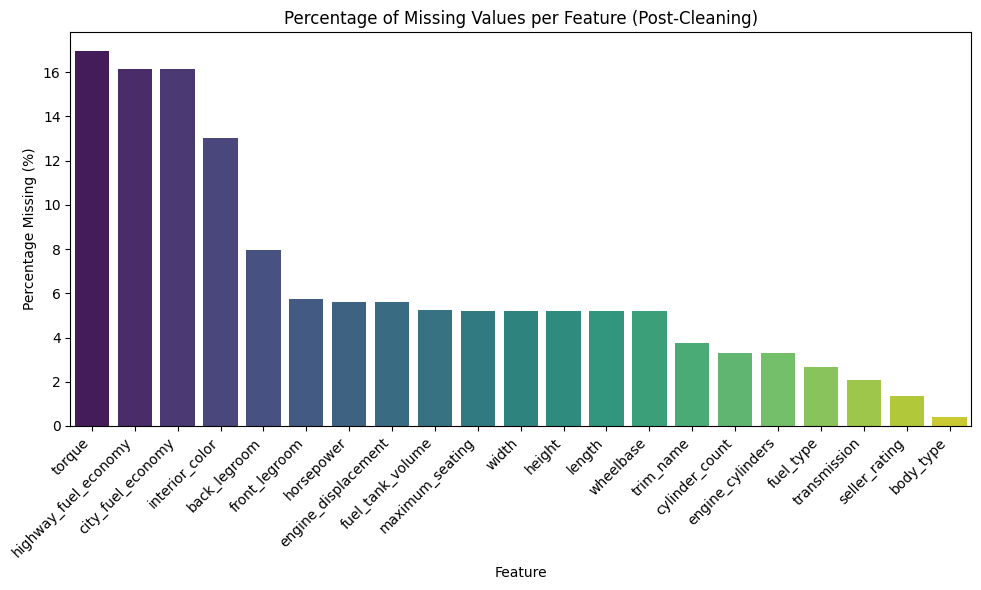

In [217]:
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title('Percentage of Missing Values per Feature (Post-Cleaning)')
plt.xlabel('Feature')
plt.ylabel('Percentage Missing (%)')
plt.tight_layout()
plt.show()

-------------

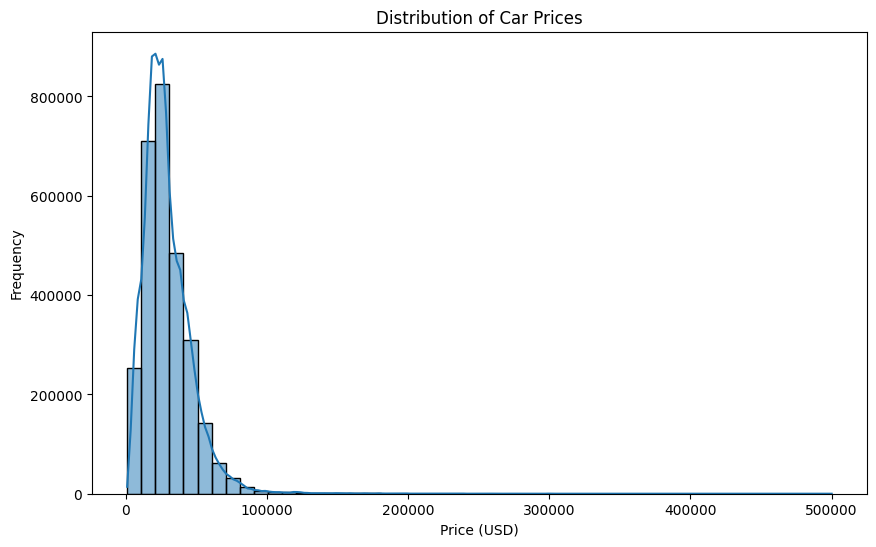

In [218]:
plt.figure(figsize=(10, 6))
sns.histplot(cars_df['price'], kde=True, bins=50)
plt.title('Distribution of Car Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x') # To avoid scientific notation
plt.show()

-----------------

In [219]:
cars_df['log_price'] = np.log1p(cars_df['price'])

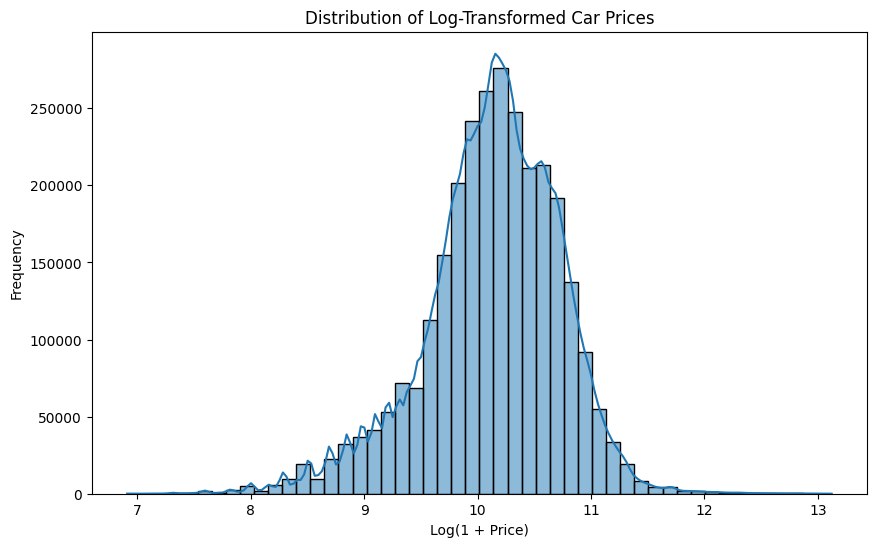

In [220]:
plt.figure(figsize=(10, 6))
sns.histplot(cars_df['log_price'], kde=True, bins=50)
plt.title('Distribution of Log-Transformed Car Prices')
plt.xlabel('Log(1 + Price)')
plt.ylabel('Frequency')
plt.show()

-------------------

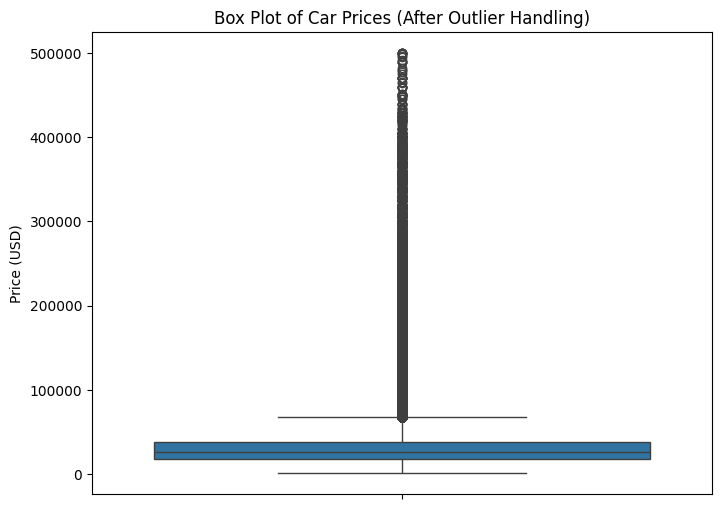

In [221]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=cars_df['price'])
plt.title('Box Plot of Car Prices (After Outlier Handling)')
plt.ylabel('Price (USD)')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

-------------------

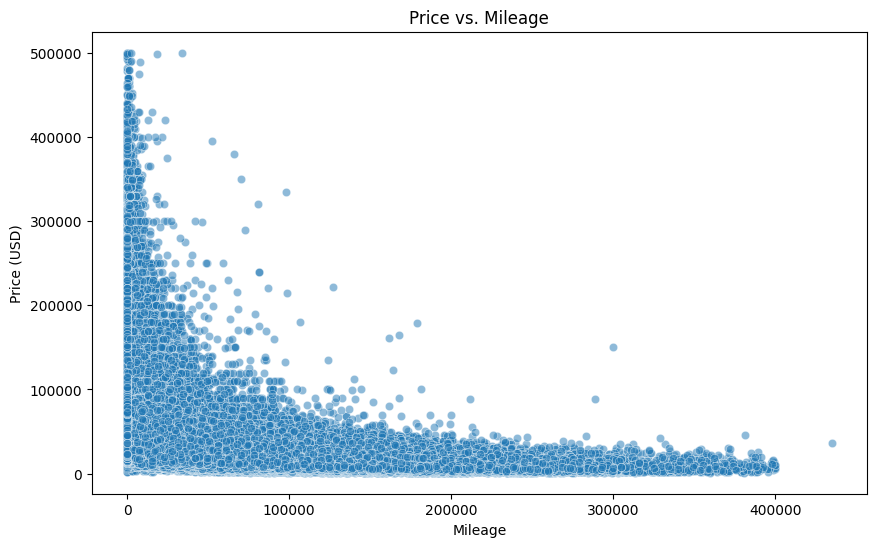

In [222]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mileage', y='price', data=cars_df, alpha=0.5)
plt.title('Price vs. Mileage')
plt.xlabel('Mileage')
plt.ylabel('Price (USD)')
plt.ticklabel_format(style='plain', axis='x')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

--------------

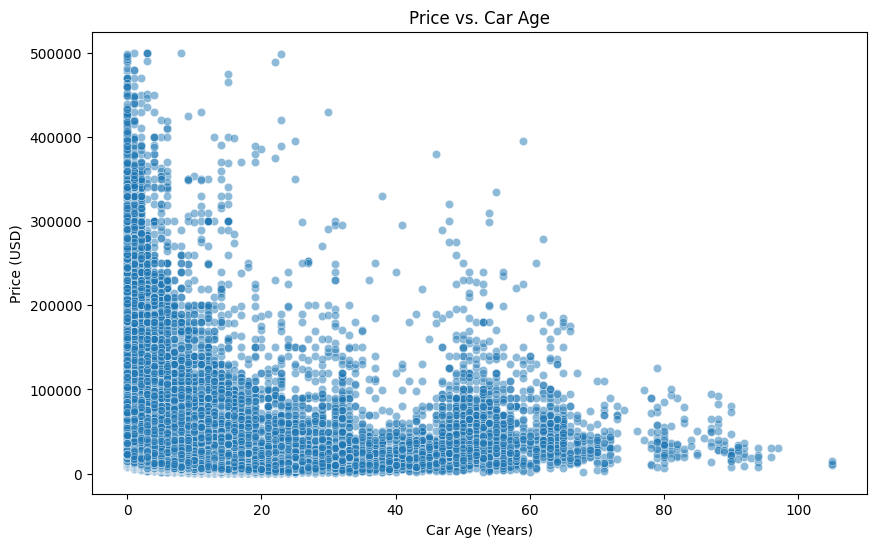

In [223]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='car_age', y='price', data=cars_df, alpha=0.5)
plt.title('Price vs. Car Age')
plt.xlabel('Car Age (Years)')
plt.ylabel('Price (USD)')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

----------------

In [224]:
top_n = 10
top_makes = cars_df['make_name'].value_counts().nlargest(top_n).index
cars_df_top_makes = cars_df[cars_df['make_name'].isin(top_makes)]

C:\Users\adand\AppData\Local\Temp\ipykernel_22568\343894466.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='make_name', y='price', data=cars_df_top_makes, order=top_makes, palette="viridis")


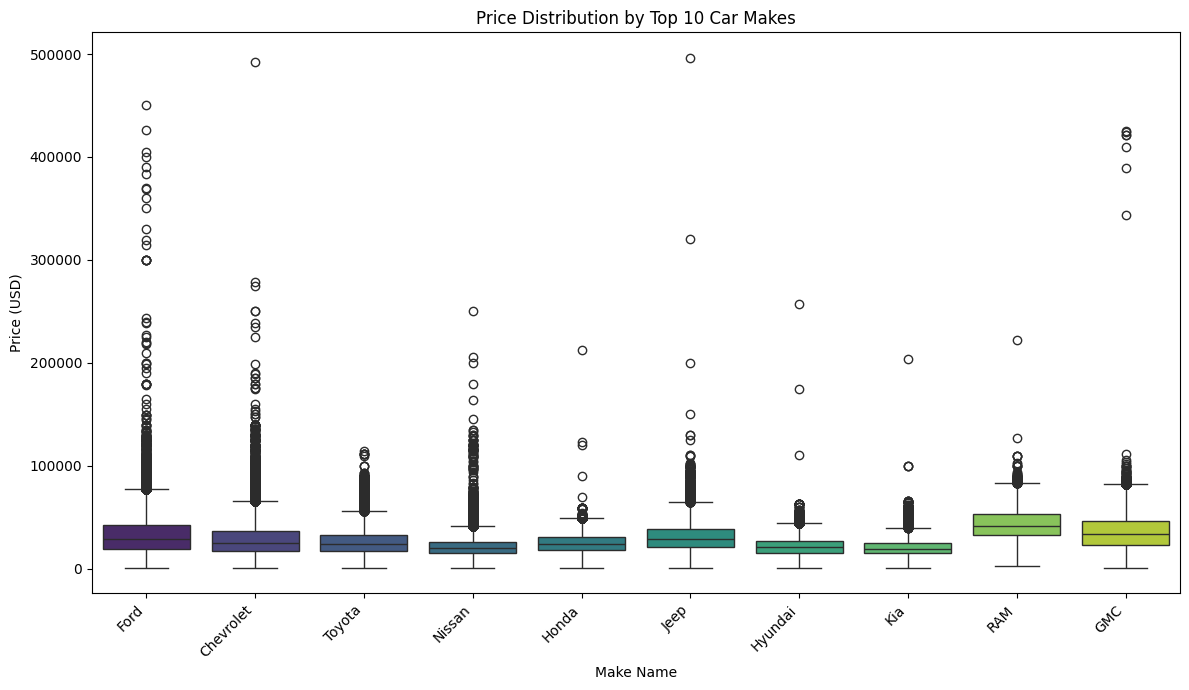

In [225]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='make_name', y='price', data=cars_df_top_makes, order=top_makes, palette="viridis")
plt.title(f'Price Distribution by Top {top_n} Car Makes')
plt.xlabel('Make Name')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45, ha="right")
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

-----------------

C:\Users\adand\AppData\Local\Temp\ipykernel_22568\649025568.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='body_type', y='price', data=cars_df, order=ordered_body_types, palette="coolwarm")


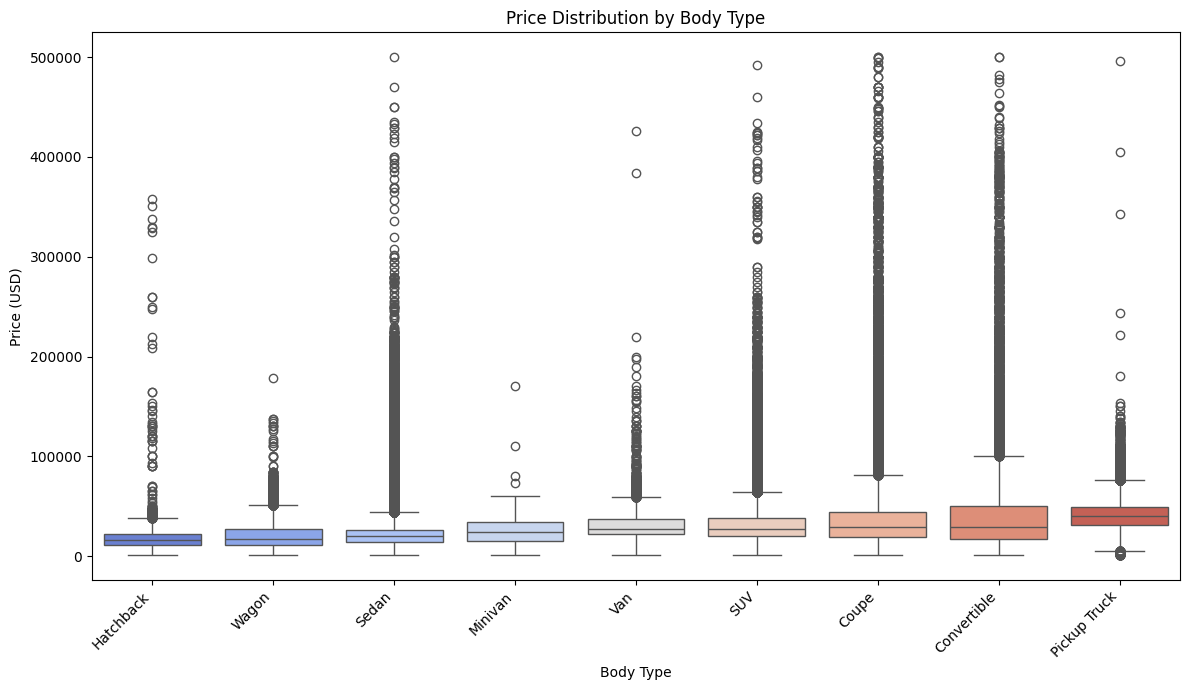

In [226]:
plt.figure(figsize=(12, 7))
ordered_body_types = cars_df.groupby('body_type')['price'].median().sort_values().index
sns.boxplot(x='body_type', y='price', data=cars_df, order=ordered_body_types, palette="coolwarm")
plt.title('Price Distribution by Body Type')
plt.xlabel('Body Type')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45, ha="right")
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

------------------

C:\Users\adand\AppData\Local\Temp\ipykernel_22568\10694792.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='fuel_type', y='price', data=cars_df, order=ordered_fuel_types, palette="Set2")


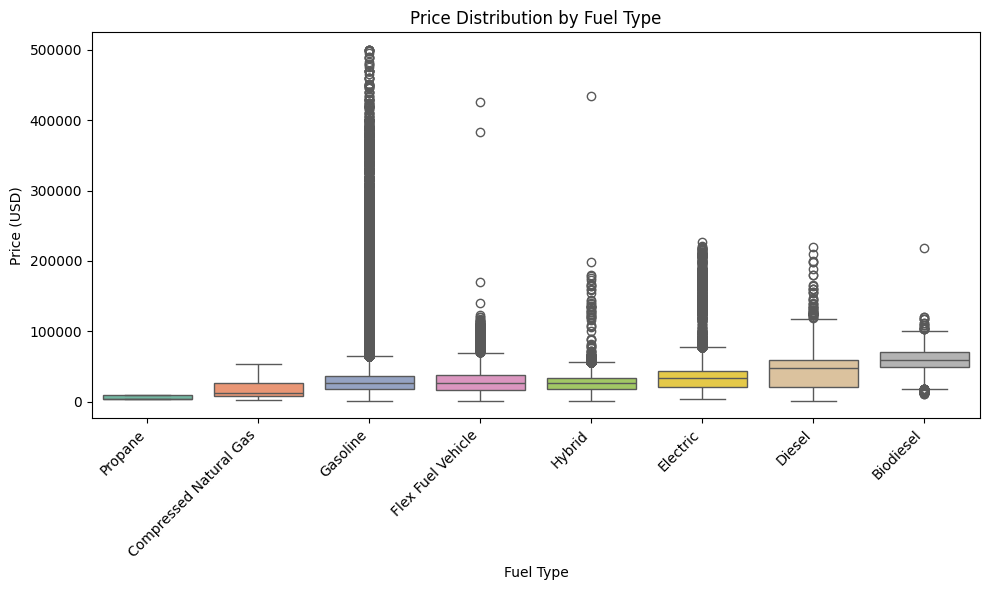

In [227]:
plt.figure(figsize=(10, 6))
ordered_fuel_types = cars_df.groupby('fuel_type')['price'].median().sort_values().index
sns.boxplot(x='fuel_type', y='price', data=cars_df, order=ordered_fuel_types, palette="Set2")
plt.title('Price Distribution by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45, ha="right")
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

----------------

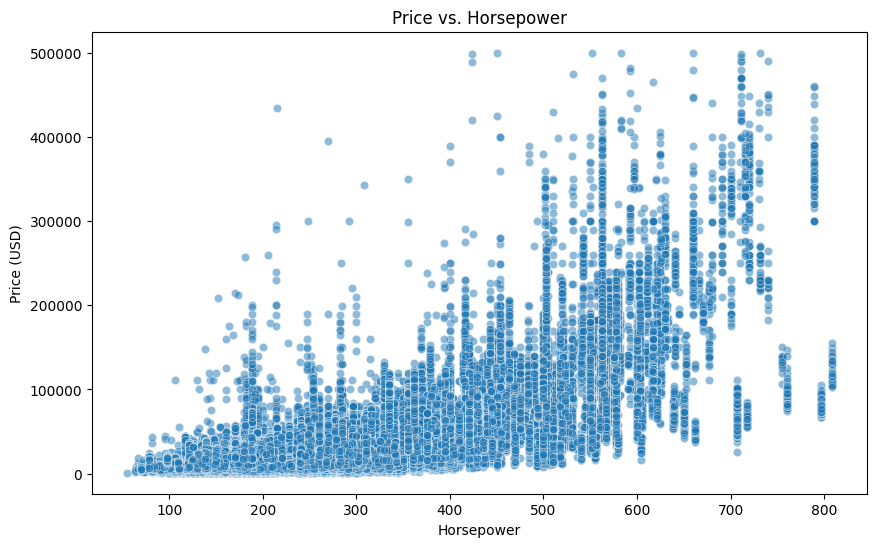

In [228]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='horsepower', y='price', data=cars_df, alpha=0.5)
plt.title('Price vs. Horsepower')
plt.xlabel('Horsepower')
plt.ylabel('Price (USD)')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

---------------

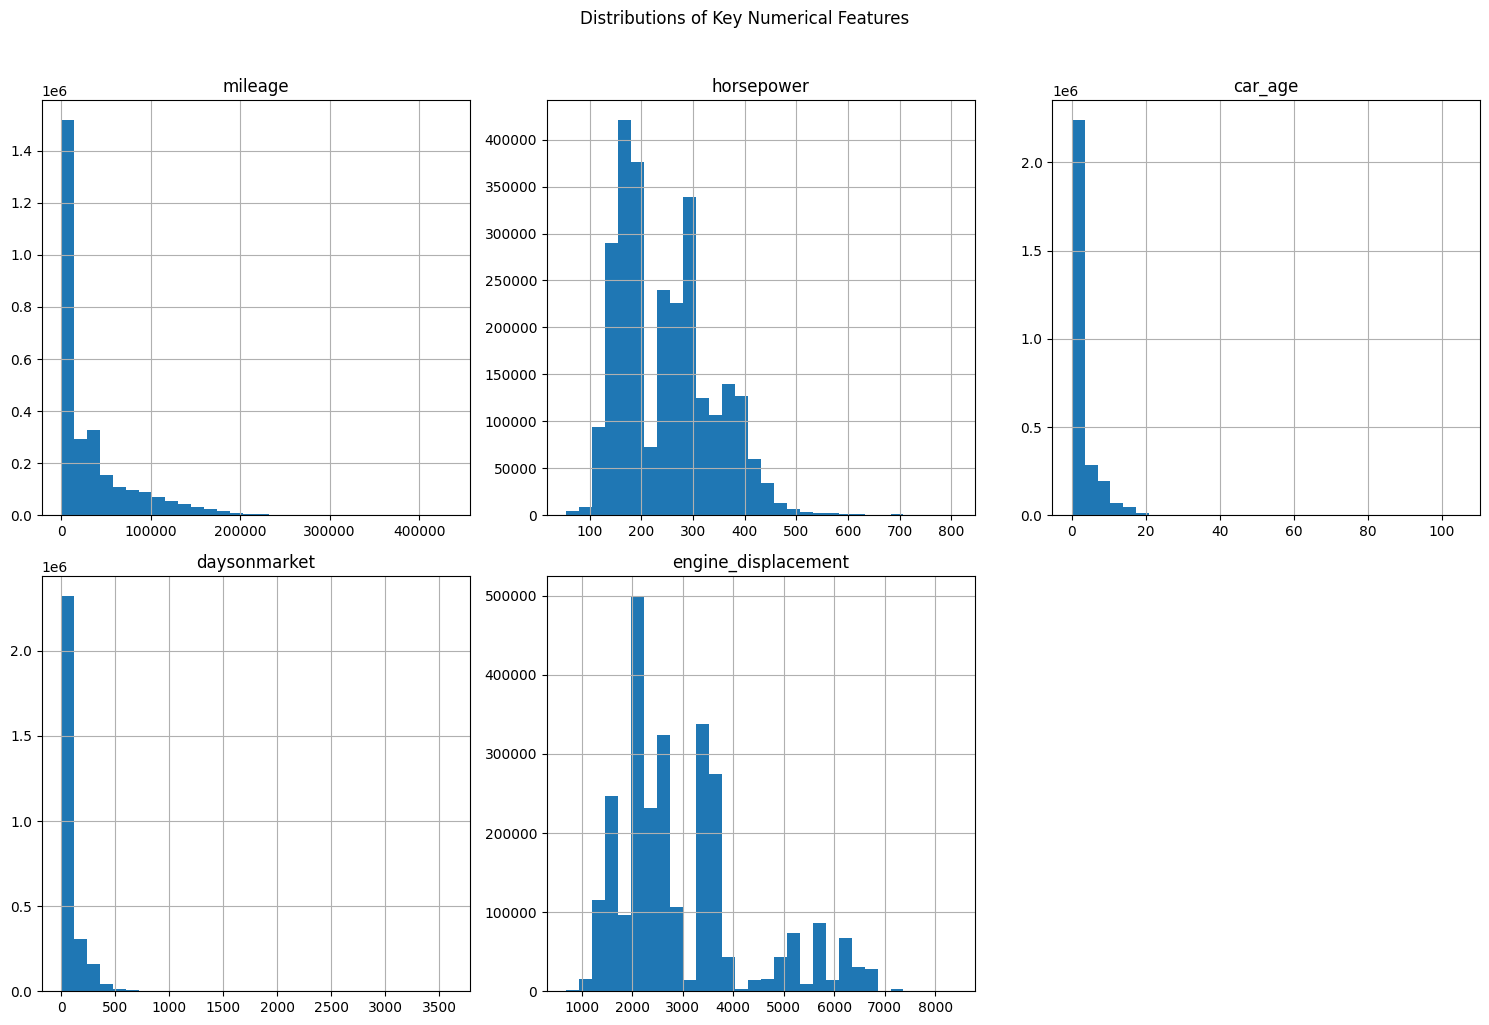

In [229]:
numerical_features_to_plot = ['mileage', 'horsepower', 'car_age', 'daysonmarket', 'engine_displacement']
cars_df[numerical_features_to_plot].hist(bins=30, figsize=(15, 10), layout=(2, 3))
plt.suptitle('Distributions of Key Numerical Features', y=1.02)
plt.tight_layout()
plt.show()

------------

C:\Users\adand\AppData\Local\Temp\ipykernel_22568\3439733469.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_cats.index, y=top_n_cats.values, palette="crest", order=top_n_cats.index)


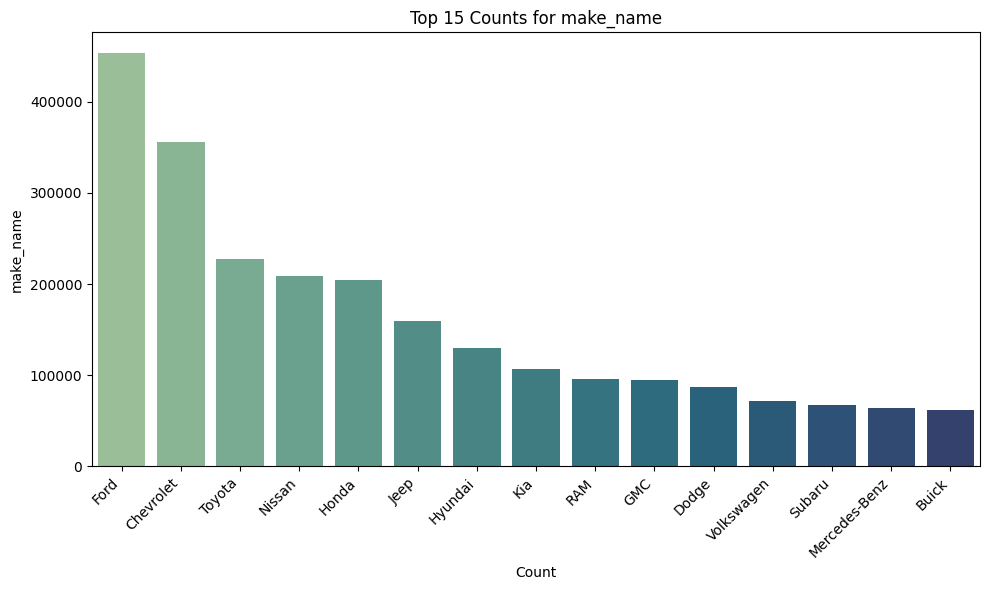

C:\Users\adand\AppData\Local\Temp\ipykernel_22568\3439733469.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=feature, data=cars_df, palette="crest", order=cars_df[feature].value_counts().index)


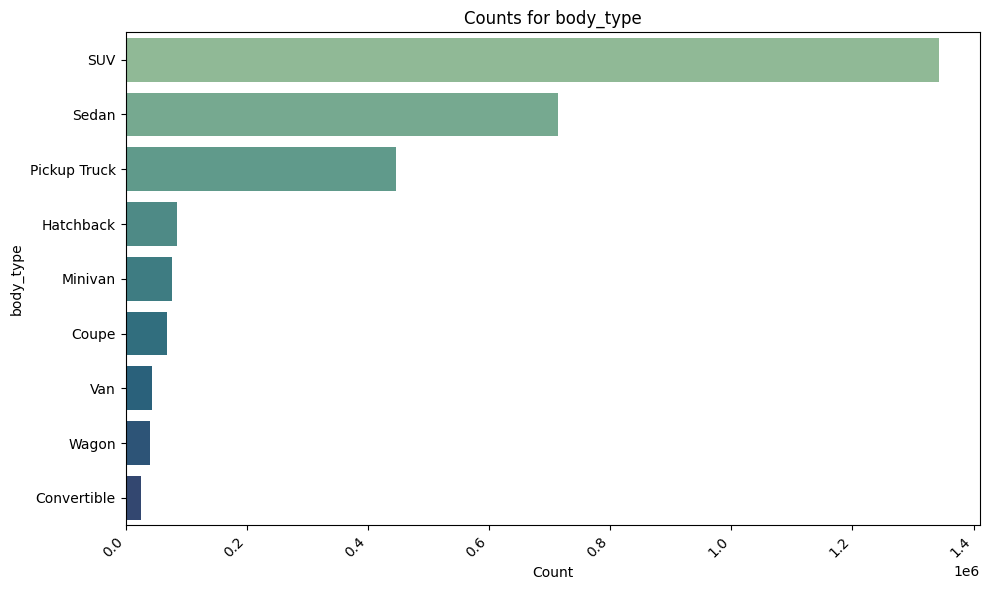

C:\Users\adand\AppData\Local\Temp\ipykernel_22568\3439733469.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=feature, data=cars_df, palette="crest", order=cars_df[feature].value_counts().index)


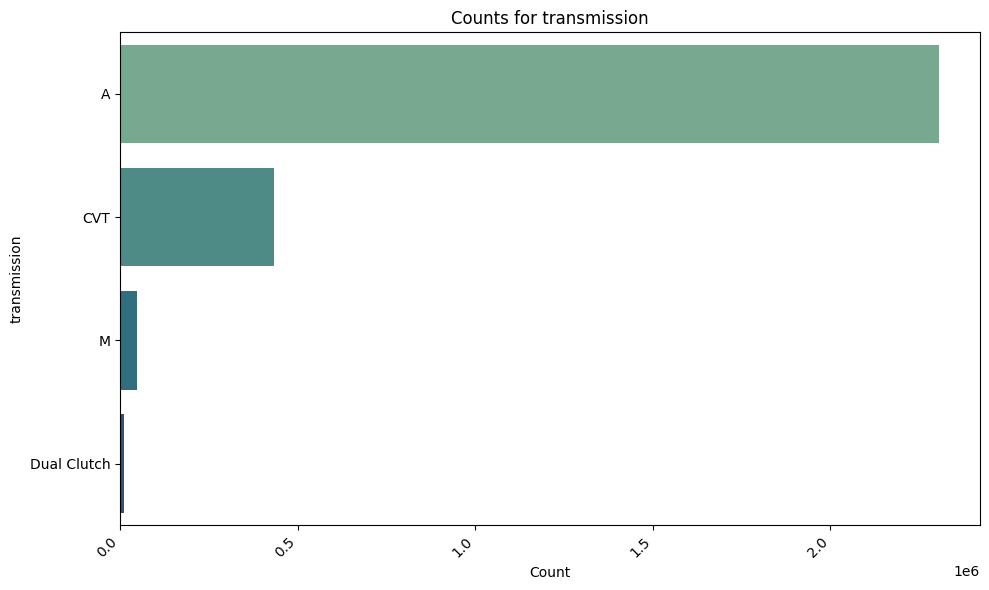

In [230]:
categorical_features_to_plot = ['make_name', 'body_type', 'transmission']

for feature in categorical_features_to_plot:
    plt.figure(figsize=(10, 6))
    # For high-cardinality features like 'make_name', plot top N
    if cars_df[feature].nunique() > 15:
        top_n_cats = cars_df[feature].value_counts().nlargest(15)
        sns.barplot(x=top_n_cats.index, y=top_n_cats.values, palette="crest", order=top_n_cats.index)
        plt.title(f'Top 15 Counts for {feature}')
    else:
        sns.countplot(y=feature, data=cars_df, palette="crest", order=cars_df[feature].value_counts().index)
        plt.title(f'Counts for {feature}')

    plt.xlabel('Count')
    plt.ylabel(feature)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

---------------

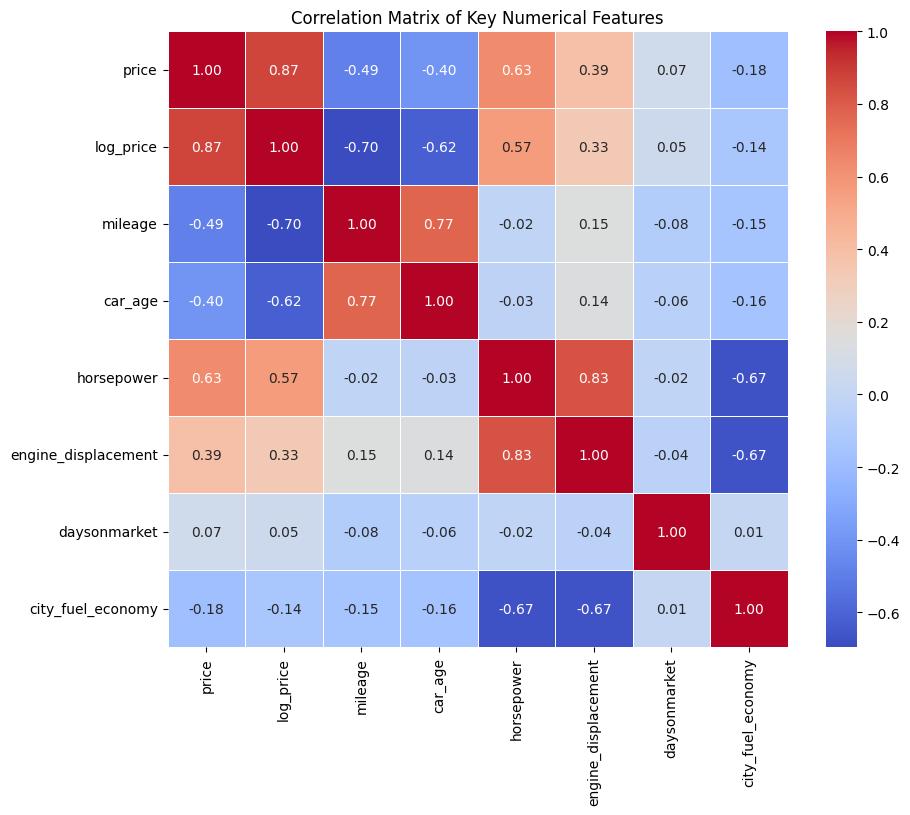

In [231]:
# Select numerical columns for correlation matrix
# Add other relevant numerical columns from your actual EDA
numerical_cols_for_corr = ['price', 'log_price', 'mileage', 'car_age', 'horsepower', 'engine_displacement', 'daysonmarket', 'city_fuel_economy'] 

# Ensure columns exist and are numeric before calculating correlation
valid_numerical_cols = [col for col in numerical_cols_for_corr if col in cars_df.columns and pd.api.types.is_numeric_dtype(cars_df[col])]

if len(valid_numerical_cols) > 1: # Need at least 2 columns for correlation
    correlation_matrix = cars_df[valid_numerical_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Correlation Matrix of Key Numerical Features')
    plt.show()
else:
    print("Not enough valid numerical columns to generate a correlation matrix from the specified list.")

----------------